In [32]:
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [33]:
import seaborn as sns
import pandas as pd
import numpy as np

In [34]:
sales_train = pd.read_csv("../data/sales_train_validation_afcs2023.csv")
sales_test = pd.read_csv("../data/sales_test_validation_afcs2022.csv")
prices = pd.read_csv("../data/sell_prices_afcs2023.csv")
calendar = pd.read_csv("../data/calendar_afcs2023.csv", parse_dates=["date"])

In [35]:
date_range = pd.Series(pd.date_range(start="2011-01-29", end="2016-06-19", freq='D')).dt.strftime('%Y-%m-%d').to_list()
date_range.insert(0, "id")
sales_train.columns = date_range[:len(sales_train.columns)]
sales_train[['item_id', "Loc1", "Loc2", "Type"]] = sales_train.id.str.rsplit("_", n=3, expand=True)
sales_train = sales_train.drop("id", axis=1)
sales_train = sales_train.melt(id_vars=['item_id', "Loc1", "Loc2", "Type"], var_name="date", value_name="sales_amount")
sales_train["date"] = pd.to_datetime(sales_train["date"])

In [36]:
date_range = pd.Series(pd.date_range(start="2016-04-25", end="2016-06-19", freq='D')).dt.strftime('%Y-%m-%d').to_list()
date_range.insert(0, "id")
sales_test.columns = date_range[:len(sales_test.columns)]
sales_test[['item_id', "Loc1", "Loc2", "Type"]] = sales_test.id.str.rsplit("_", n=3, expand=True)
sales_test = sales_test.drop("id", axis=1)
sales_test = sales_test.melt(id_vars=['item_id', "Loc1", "Loc2", "Type"], var_name="date", value_name="sales_amount")
sales_test["date"] = pd.to_datetime(sales_test["date"])

In [37]:
sales_train = pd.merge(sales_train, calendar, on='date')
sales_train = sales_train.drop(columns=['Loc1', 'Loc2', "Type"])
sales_train = pd.merge(sales_train, prices, on=['wm_yr_wk', 'item_id'],how ='left')
sales_train = sales_train.drop('store_id',axis=1)

In [38]:
sales_test = pd.merge(sales_test, calendar, on='date')
sales_test = sales_test.drop(columns=['Loc1', 'Loc2', "Type"])
sales_test = pd.merge(sales_test, prices, on=['wm_yr_wk', 'item_id'],how ='left')
sales_test = sales_test.drop('store_id',axis=1)

### Items were added at different times

In [39]:
date_added = sales_train[sales_train.sell_price.notna()].groupby("item_id")["date"].min().reset_index()

In [40]:
date_added["week_added"] = 1
sales_train = sales_train.merge(date_added, on=["item_id", "date"], how='left')
sales_train["week_added"] = sales_train["week_added"].fillna(0)

In [41]:
sales_test["week_added"] = 0

### Cleaning categorical values to ease one-hot encoding later on

In [42]:
sales_train[['event_name_1', 'event_name_2']] = sales_train[['event_name_1', 'event_name_2']].fillna("No event")
sales_train[['event_type_1', 'event_type_2']] = sales_train[['event_type_1', 'event_type_2']].fillna("No event type")
sales_train = sales_train.sort_values(["item_id", "date"])

In [43]:
sales_test[['event_name_1', 'event_name_2']] = sales_test[['event_name_1', 'event_name_2']].fillna("No event")
sales_test[['event_type_1', 'event_type_2']] = sales_test[['event_type_1', 'event_type_2']].fillna("No event type")
sales_test = sales_test.sort_values(["item_id", "date"])

### Feature engineering on sales price

##### Creating Classification Of Price
We begin by filling Null values for sales price if no items not added yet (do not have a price).


In [44]:
sales_train['sell_price'] = sales_train['sell_price'].fillna(0)
quantiles = sales_train.sell_price.quantile([0, 0.25, 0.5, 0.75, 1]).to_list()
sales_train["price_category"] = pd.cut(sales_train["sell_price"], quantiles, labels=["low", "mid-low", "mid-high", "high"])
sales_train.loc[sales_train["price_category"].isnull(), "price_category"] = "low"

In [45]:
sales_test['sell_price'] = sales_test['sell_price'].fillna(0)
sales_test["price_category"] = pd.cut(sales_test["sell_price"], quantiles, labels=["low", "mid-low", "mid-high", "high"])
sales_test.loc[sales_test["price_category"].isnull(), "price_category"] = "low"

### Connecting TEST AND TRAIN DATA

Previously not bound, since:
1. We assume the items were added prior to the testing period
2. We categorise sales category based on the quantiles of the train set, otherwise we will have a data leak from the test set.

In [46]:
assert np.all(sales_test.columns == sales_train.columns)
full_data = pd.concat([sales_train, sales_test])

#### Creating weekly shifted/ lagged values

The assumption is the following:
Since we are transposing $price_t$ to $price_{t+1}$, for $price_0$ for each product we need to backfill values for the first week, since these were shifted into the future.

In [47]:
lagged_8_days = (
    full_data
    .set_index("date")
    .groupby("item_id", as_index=False)[["sell_price", "price_category", "item_id", "sales_amount", "event_name_1", "event_name_2", "event_type_1", "event_type_2"]]
    .shift(periods=7)
    .reset_index()
    .bfill()
    .rename(columns={
        "sell_price": "7dl_sell_price",
        "price_category": "7dl_price_category",
        "sales_amount": "7dl_sales_amount",
        "event_name_1": "7dl_event_name_1",
        "event_name_2": "7dl_event_name_2",
        "event_type_1": "7dl_event_type_1",
        "event_type_2": "7dl_event_type_2"
    })
)

full_data = full_data.merge(lagged_8_days, on=["date", "item_id"])

### Adding Weekly, Monthly, Quaterly and Yearly Percent change in prices

In [48]:
weekly_changes_in_price = (
    full_data
    .groupby(['item_id', "wm_yr_wk"])['sell_price']
    .mean()
    .pct_change()
    .reset_index()
    .rename(columns={"sell_price": "weekly_pct_change"})
    .fillna(0)
)
weekly_changes_in_price.loc[weekly_changes_in_price["weekly_pct_change"] == np.inf, "weekly_pct_change"] = 0
weekly_changes_in_price["weekly_pct_change"] = weekly_changes_in_price["weekly_pct_change"] * 100

In [49]:
monthly_changes_in_price = (
    full_data
    .set_index("date")
    .groupby(['item_id', pd.Grouper(freq="M")])['sell_price']
    .mean()
    .pct_change()
    .reset_index()
    .rename(columns={"sell_price": "monthly_pct_change"})
    .fillna(0)
)
monthly_changes_in_price.loc[monthly_changes_in_price["monthly_pct_change"] == np.inf, "monthly_pct_change"] = 0
monthly_changes_in_price["monthly_pct_change"] = monthly_changes_in_price["monthly_pct_change"] * 100

In [50]:
quaterly_changes_in_price = (
    full_data
    .set_index("date")
    .groupby(['item_id', pd.Grouper(freq="Q")])['sell_price']
    .mean()
    .pct_change()
    .reset_index()
    .rename(columns={"sell_price": "qrt_pct_change"})
    .fillna(0)
)
quaterly_changes_in_price.loc[quaterly_changes_in_price["qrt_pct_change"] == np.inf, "qrt_pct_change"] = 0
quaterly_changes_in_price["qrt_pct_change"] = quaterly_changes_in_price["qrt_pct_change"] * 100

In [51]:
yearly_changes_in_price = (
    full_data
    .set_index("date")
    .groupby(['item_id', pd.Grouper(freq="Y")])['sell_price']
    .mean()
    .pct_change()
    .reset_index()
    .rename(columns={"sell_price": "yearly_pct_change"})
    .fillna(0)
)
yearly_changes_in_price.loc[yearly_changes_in_price["yearly_pct_change"] == np.inf, "yearly_pct_change"] = 0
yearly_changes_in_price["yearly_pct_change"] = yearly_changes_in_price["yearly_pct_change"] * 100

In [52]:
full_data = full_data.merge(weekly_changes_in_price, on=["item_id", "wm_yr_wk"])

In [53]:
full_data = full_data.merge(
    monthly_changes_in_price,
    left_on=[
        "item_id",
        full_data['date'].dt.to_period('M')
    ],
    right_on=[
        "item_id",
        monthly_changes_in_price['date'].dt.to_period('M')
    ]
).drop(["date_y", "key_1"], axis=1).rename(columns={"date_x":"date"})

In [54]:
full_data = full_data.merge(
    quaterly_changes_in_price,
    left_on=[
        "item_id",
        full_data['date'].dt.to_period('Q')
    ],
    right_on=[
        "item_id",
        quaterly_changes_in_price['date'].dt.to_period('Q')
    ]
).drop(["date_y", "key_1"], axis=1).rename(columns={"date_x":"date"})

In [55]:
full_data = full_data.merge(
    yearly_changes_in_price,
    left_on=[
        "item_id",
        full_data['date'].dt.to_period('Y')
    ],
    right_on=[
        "item_id",
        yearly_changes_in_price['date'].dt.to_period('Y')
    ]
).drop(["date_y", "key_1"], axis=1).rename(columns={"date_x":"date"})

### Adding Weekday, Weekend and Holiday Dummy Vars

In [56]:
full_data["is_weekday"] = full_data["weekday"].apply(lambda x: x not in ["Saturday","Sunday"])

In [57]:
full_data["is_weekend"] = full_data["weekday"].apply(lambda x: x in ["Saturday","Sunday"])

Here we can have either 0, 1 or 2 events together.

In [58]:
full_data["is_holiday"] = full_data.apply(
    lambda x: sum(
        [
            int(x["event_name_1"] != 'No event'),
            int(x["event_name_2"] != 'No event'),
        ]
    ), axis=1
)


### Adding markers for traditional ML algorithms

In [59]:
full_data["day"] = full_data["date"].dt.day
full_data["quarter"] = full_data["date"].dt.quarter
full_data["month"] = full_data["date"].dt.month
full_data["week"] = full_data["date"].dt.isocalendar().week

In [60]:
(
    full_data
    .query("`date` >= '2011-01-29' and `date` <= '2016-04-24'")
    .to_pickle("../data/fulling_connected_feature_eng_train_data.pkl")
)

(
    full_data
    .query("`date` >= '2011-01-29' and `date` <= '2016-04-24'")
    .to_csv("../data/fulling_connected_feature_eng_train_data.csv")
)

In [61]:
(
    full_data
    .query("`date` >= '2016-04-25'")
    .to_pickle("../data/fulling_connected_feature_eng_test_data.pkl")
)

(
    full_data
    .query("`date` >= '2016-04-25'")
    .to_csv("../data/fulling_connected_feature_eng_test_data.csv    ")
)

In [63]:
train = full_data.query("`date` >= '2011-01-29' and `date` <= '2016-04-24'")

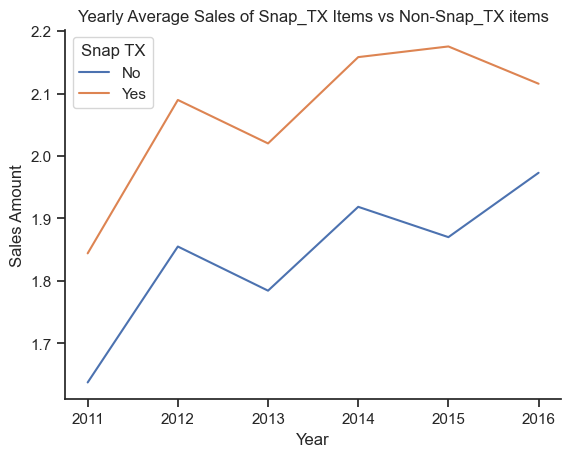

In [72]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import matplotlib.pyplot as plt

# Convert week column to string
g = sns.lineplot(
    data=train,
    x="year",
    y="sales_amount",
    hue="snap_TX",
    errorbar=None,
    estimator="mean"
).set_title("Yearly Average Sales of Snap_TX Items vs Non-Snap_TX items")
plt.xlabel("Year")
plt.ylabel("Sales Amount")
plt.legend(title='Snap TX', loc='upper left', labels=['No', 'Yes'])
plt.show()


In [83]:
train.query("`event_name_1` != 'No event'").groupby(["day", "event_name_1"], as_index=False)["event_type_1"].count().sort_values("event_type_1", ascending=False)

,day,event_name_1,event_type_1
67,17,StPatricksDay,4938
52,14,ValentinesDay,4938
114,31,Halloween,4115
1,1,NewYear,4115
95,25,Christmas,4115
...,...,...,...
36,10,Mother's day,823
35,10,LentStart,823
34,10,ColumbusDay,823
33,9,Ramadan starts,823


In [84]:
train.event_name_1.unique()

array(['No event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

/Users/mladenrm/.local/share/virtualenvs/afcs_assignments-DYfdduJW/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


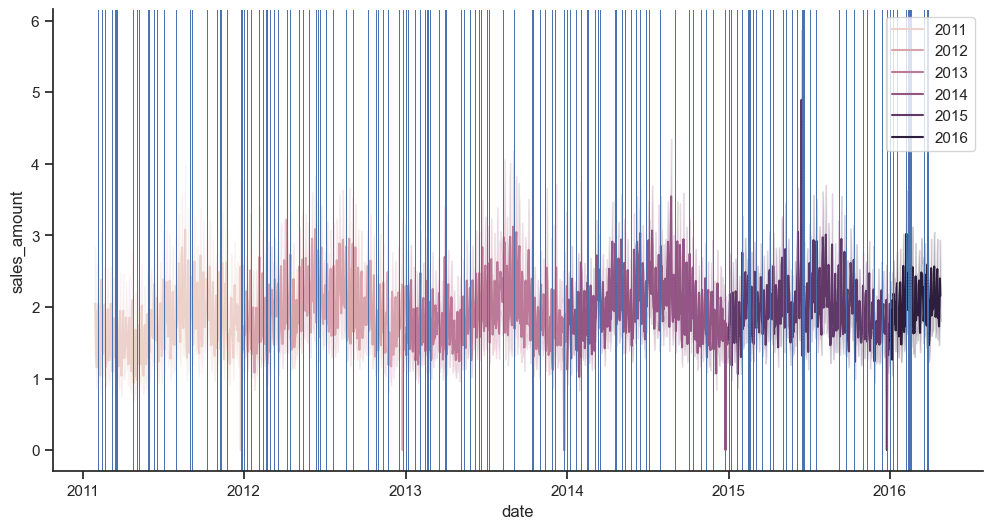

In [103]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='date', y='sales_amount', hue='year', data=train, errorbar=None)

for index, row in train.query("`event_name_1` != 'No event'").iterrows():
    ax.axvline(
        x = train.loc[index, "date"],
        ymin = 0,
        ymax = 1,
        linestyle = "dashed",
        linewidth=0.4,
        alpha=0.7
    )

plt.legend()
plt.show()